In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load a pre-trained model (ResNet50)
model = models.resnet50(pretrained=True)
model.eval()

# Image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = "D:\Project\Python\DeepLearning\CNN\images\puppy.jpg" 
image = Image.open(image_path)
input_tensor = transform(image).unsqueeze(0)


d:\Project\Python\DeepLearning\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Project\Python\DeepLearning\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:

# Target layer (last convolutional layer of ResNet)
target_layer = model.layer4[2].conv3  

# Store gradients and activations
gradients = []
activations = []

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])  # Save first-order gradient

def forward_hook(module, input, output):
    activations.append(output)  # Save feature maps

# Register hooks
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)


In [3]:
# Forward pass
output = model(input_tensor)
pred_class = output.argmax(dim=1)  # Get predicted class

# Compute gradients for the target class
model.zero_grad()
output[0, pred_class].backward(retain_graph=True)

# Extract gradients and activations
grads = gradients[0].detach()  # (batch_size, channels, H, W)
acts = activations[0].detach()  # (batch_size, channels, H, W)


d:\Project\Python\DeepLearning\.venv\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [4]:
# Compute weights: global average pooling of gradients
weights = torch.mean(grads, dim=[2, 3], keepdim=True)  # (batch_size, channels, 1, 1)

# Compute Grad-CAM heatmap
cam = torch.sum(weights * acts, dim=1).squeeze(0)  # Weighted sum over channels

# Apply ReLU
cam = F.relu(cam)

# Normalize heatmap
cam -= cam.min()
cam /= cam.max()


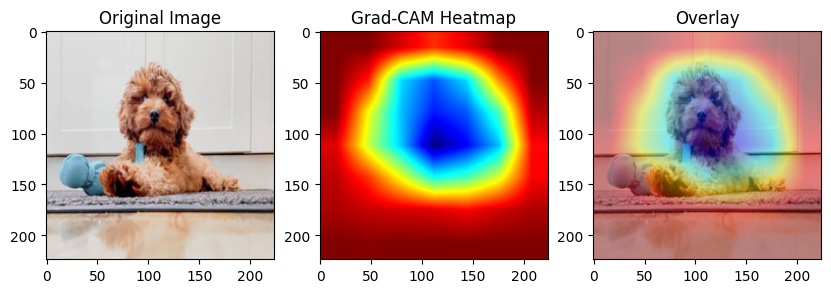

In [5]:
# Resize heatmap to match image size
heatmap = cv2.resize(cam.numpy(), (224, 224))

# Convert to colormap
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Load original image as numpy array
original = np.array(image.resize((224, 224)))

# Superimpose heatmap on original image
superimposed = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(original)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(superimposed)
plt.title("Overlay")
plt.show()
